This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/models.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [40]:
import math
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [29]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry

In [30]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
VALIDATION_FOLDER = EXPERIMENT_FOLDER / 'validation-recordings'
MODELS_FOLDER = Path().resolve().parent / 'models'
print(MODELS_FOLDER)

C:\Users\esdan\Desktop\AO\models


## Generate recording ground truth

In [31]:
recording = VALIDATION_FOLDER / 'date_2022-05-20;time_16-59-56'

def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('microphone*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp

get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

,X,Vx,Vw,slip,wheel_rotation
timestamp,,,,,
1.653034e+09,0.00,0.0000,0.0000,0.00000,0.000000
1.653034e+09,0.00,0.0000,0.0000,0.00000,0.002397
1.653034e+09,0.11,0.0011,7.0113,0.91011,0.703520
1.653034e+09,1.29,0.0118,9.8078,0.31066,1.684300
1.653034e+09,3.71,0.0242,10.1710,-0.36320,2.701400


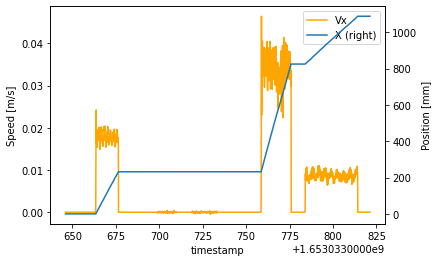

In [32]:
def get_recording_ground_truth(recording: Path) -> pd.DataFrame:
    ground_truth_path = recording / 'ground_truth.csv'
    if ground_truth_path.exists():
        return pd.read_csv(ground_truth_path, index_col='timestamp')
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.to_csv(ground_truth_path, index_label='timestamp')
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ax = ground_truth.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
ground_truth.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [mm]')
ground_truth.head()

## Model definition

In [33]:
from abc import abstractmethod

class AcousticOdometryModel(nn.Module):

    @abstractmethod
    def forward(self, x):
        pass

# Reset the subclasses to allow changes without restarting the kernel
for subclass in AcousticOdometryModel.__subclasses__():
    del subclass

In [34]:
class CNNet(AcousticOdometryModel):
    def __init__(self, classes: int):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(210816, 512)
        self.fc2 = nn.Linear(512, classes)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

In [35]:
AcousticOdometryModel.__subclasses__()

[__main__.CNNet]

## Apply model to recording

In [51]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cuda device


In [ ]:
def acoustic_odometry(wav_file: Path, model_path: Path) -> pd.DataFrame:
    model = torch.load(model_path)
    # TODO This should be loaded from the model configuration
    segment_duration = 1200  # [milliseconds]
    segment_overlap = 1000  # [milliseconds]
    frame_features = 256
    frame_duration = 10  # [milliseconds])
    extractor = ao.extractor.GammatoneFilterbank
    extractor_kwargs = {}
    compression = math.log10

    wav_data, sample_rate = ao.io.wave_read(wav_file)
    # TODO load config
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    start = config['start_timestamp']
    frame_samples = int(frame_duration * sample_rate / 1000)
    if compression:
        compression = np.vectorize(compression)
    extract = extractor(
        num_samples=frame_samples,
        num_features=frame_features,
        sample_rate=sample_rate,
        **extractor_kwargs
        )
    # TODO preallocate odometry dataframe
    odom = pd.DataFrame(columns=['X', 'Vx'])
    odom.loc[start] = [0, 0]
    x_index = odom.columns.get_loc('X')
    for segment in ao.dataset.audio.segment(
        wav_data, sample_rate, segment_duration, segment_overlap
        ):
        end = start + segment_duration / 1000
        features = ao.dataset.audio.features(
            segment, frame_samples, extract=extract, compression=compression
            )
        pred = model(
            torch.from_numpy(features[np.newaxis,
                                      np.newaxis, :, :]).float().to(DEVICE)
            )
        odom.loc[end, 'Vx'] = pred.argmax(1).sum().item()
        odom.loc[end, 'X'] = (
            odom.iloc[-2, x_index] + odom.loc[end, 'Vx'] *
            (segment_duration - segment_overlap)
            )
        start = end - segment_overlap / 1000
    return odom


odom = acoustic_odometry(
    wav_file=recording / 'microphone0.wav',
    model_path=MODELS_FOLDER /
    'name_numpy-arrays;date_2022-05-23;time_13-39-14.pt'
    )

,X,Vx
1.653034e+09,0.0,0.0
1.653034e+09,0.0,0.0
1.653034e+09,0.0,0.0
1.653034e+09,0.0,0.0
1.653034e+09,0.0,0.0


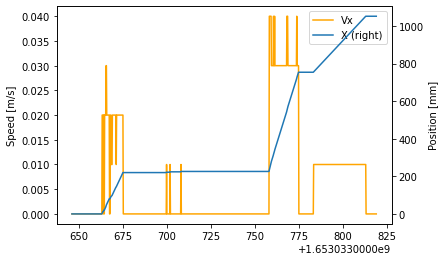

In [70]:
_odom = odom.copy()
_odom.loc[:, 'Vx'] /= 100  # [cm/s] -> [m/s]
_odom.loc[:, 'X'] /= 100  # [cm] -> [m]
ax = _odom.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
_odom.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [mm]')
_odom.head()